In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import json
import os

# Define the path where your kaggle.json file is located
kaggle_json_path = "/content/kaggle.json"

!kaggle datasets download -d dheerajperumandla/drowsiness-dataset --unzip -p /content/dataset

Dataset URL: https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset
License(s): unknown
 93% 149M/161M [00:01<00:00, 140MB/s]
100% 161M/161M [00:01<00:00, 117MB/s]


In [3]:

import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Create Label Variable

In [4]:
labels = os.listdir(r"/content/dataset/train")

In [5]:
labels
#Show label and create labels variable

['yawn', 'no_yawn', 'Closed', 'Open']

## Show a random image

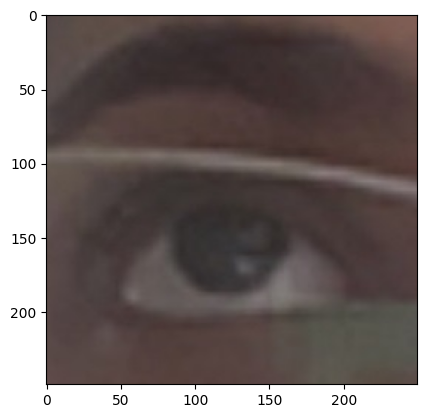

In [6]:
import matplotlib.pyplot as plt
import os
import random
dir_path = r"/content/dataset/train/Open"
def images_path():
  random_img = random.choice(os.listdir(dir_path))
  imags_path = os.path.join(dir_path, random_img)
  return imags_path
image_path = images_path()
plt.imshow(plt.imread(image_path))

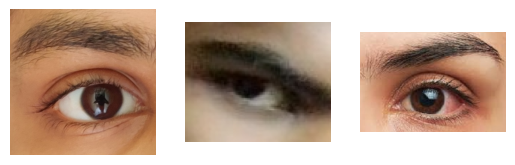

In [7]:
# Load and display multiple images
image_path1 = images_path()
image_path2 = images_path()
image_path3 = images_path()
image_paths = [image_path1,image_path2,image_path3]
num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images)

for i, image_path in enumerate(image_paths):
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

## Create a and show Image array

In [8]:
a = plt.imread(r"/content/dataset/train/Closed/_10.jpg")

## Image shape

In [9]:
a.shape

(127, 131, 3)

## Display the image of a yawning face without the background, using the array representation of the face image.


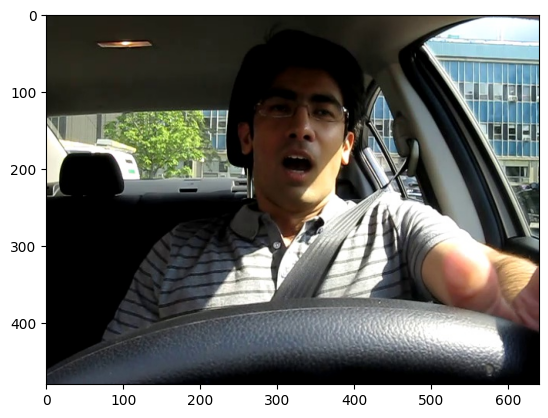

In [10]:
plt.imshow(plt.imread(r"/content/dataset/train/yawn/59.jpg"))

## Extract only the face region from both yawn and not_yawn images.

In [11]:
def face_for_yawn(direc=r"/content/dataset/train", face_cas_path=r"/content/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    face_cascade = cv2.CascadeClassifier(face_cas_path)

    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            try:
                image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
                faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
                for (x, y, w, h) in faces:
                    roi_color = image_array[y:y+h, x:x+w]
                    resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                    yaw_no.append([resized_array, class_num1])
            except Exception as e:
                print(f"Error processing image {image}: {e}")

    return yaw_no

## For Closed and Open eye

In [12]:
def get_data(dir_path=r"/content/dataset/train"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []

    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label) + 2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(f"Error processing image {img}: {e}")

    return data

## Expand the dataset by adding more data and convert the data into an array format.

In [13]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)

    # Ensure all images and labels are correctly formatted
    images = []
    labels = []

    for item in yaw_no:
        images.append(item[0])
        labels.append(item[1])

    return np.array(images), np.array(labels)

## New variable to store

In [14]:
new_images, new_labels = append_data()
print("Data shape:", new_images.shape, new_labels.shape)

0
1
2
3
Data shape: (1925, 145, 145, 3) (1925,)


## Separate the labels and features in the dataset

## Reshape images X

In [15]:
X = np.array(new_images)
X = X.reshape(-1, 145, 145, 3)

In [16]:
X.shape

(1925, 145, 145, 3)

## Perform label binarization.

In [17]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(new_labels)

## Label array

In [18]:
y = np.array(y)

In [19]:
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

## Train Test split

In [20]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [21]:
len(X_test)

578

## Import some dependencies

In [22]:
from tensorflow.python.keras.layers import Lambda, Dropout
from tensorflow.python.keras.layers.advanced_activations import ELU, LeakyReLU, ReLU
from tensorflow.python.keras import activations
from keras import callbacks, layers, metrics, regularizers
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation,SimpleRNN
import cv2
import os
import numpy as np
import pandas as pd
import pickle


## Data Augmentation

In [23]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Build and train CNN model

In [24]:
model_CNN = keras.models.Sequential()

model_CNN.add(Conv2D(filters= 256, kernel_size=(3, 3), activation="relu", input_shape=(145,145,3)))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 128, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 64, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 32, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(keras.layers.Flatten())
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.5))

model_CNN.add(keras.layers.Dense(64, activation="relu"))
model_CNN.add(keras.layers.Dense(4, activation="softmax"))

model_CNN.build(input_shape=(None, 145, 145, 3))
model_CNN.summary()

model_CNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 143, 143, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 143, 143, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 69, 69, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 69, 69, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1568)                │           6,272 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 503,332 (1.92 MB)

 Trainable params: 499,236 (1.90 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [25]:
# Add Callback
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', mode='min', patience=5, verbose=1)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [mcp_save]

In [26]:
history_CNN = model_CNN.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator), callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5762 - loss: 1.0530

43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 406ms/step - accuracy: 0.5789 - loss: 1.0464 - val_accuracy: 0.4152 - val_loss: 1.2036
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8165 - loss: 0.5185

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.8167 - loss: 0.5175 - val_accuracy: 0.5260 - val_loss: 1.1133
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.8477 - loss: 0.3568 - val_accuracy: 0.5675 - val_loss: 1.1626
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.8231 - loss: 0.4329 - val_accuracy: 0.5311 - val_loss: 1.1242
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8502 - loss: 0.3590

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.8502 - loss: 0.3595 - val_accuracy: 0.6557 - val_loss: 0.8556
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8758 - loss: 0.2931

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.8759 - loss: 0.2927 - val_accuracy: 0.6747 - val_loss: 0.8314
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.8865 - loss: 0.2824 - val_accuracy: 0.4827 - val_loss: 1.3867
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.8903 - loss: 0.2752 - val_accuracy: 0.3720 - val_loss: 4.4504
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.9028 - loss: 0.2413 - val_accuracy: 0.6782 - val_loss: 1.0451
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.9085 - loss: 0.2084 - val_accuracy: 0.6401 - val_loss: 1.1308
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9175 - loss: 0.2126

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 0.9176 - loss: 0.2123 - val_accuracy: 0.8270 - val_loss: 0.4848
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8981 - loss: 0.1958

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.8984 - loss: 0.1957 - val_accuracy: 0.8806 - val_loss: 0.3156
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.9392 - loss: 0.1643 - val_accuracy: 0.8564 - val_loss: 0.3669
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.9279 - loss: 0.1974 - val_accuracy: 0.8685 - val_loss: 0.3441
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9234 - loss: 0.1810

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9236 - loss: 0.1808 - val_accuracy: 0.9360 - val_loss: 0.1958
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9330 - loss: 0.1514 - val_accuracy: 0.9343 - val_loss: 0.2014
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.8986 - loss: 0.2562 - val_accuracy: 0.9239 - val_loss: 0.2383
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.9261 - loss: 0.1793 - val_accuracy: 0.9256 - val_loss: 0.2421
Epoch 19/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9280 - loss: 0.1751

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.9278 - loss: 0.1752 - val_accuracy: 0.9464 - val_loss: 0.1945
Epoch 20/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.9238 - loss: 0.1695 - val_accuracy: 0.9343 - val_loss: 0.1952
Epoch 21/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9479 - loss: 0.1283

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9477 - loss: 0.1286 - val_accuracy: 0.9498 - val_loss: 0.1809
Epoch 22/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.9440 - loss: 0.1288 - val_accuracy: 0.9481 - val_loss: 0.1824
Epoch 23/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.9429 - loss: 0.1215 - val_accuracy: 0.9533 - val_loss: 0.2009
Epoch 24/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9497 - loss: 0.1224

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.9495 - loss: 0.1230 - val_accuracy: 0.9585 - val_loss: 0.1547
Epoch 25/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.9469 - loss: 0.1449 - val_accuracy: 0.9394 - val_loss: 0.2443
Epoch 26/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.9471 - loss: 0.1233 - val_accuracy: 0.9377 - val_loss: 0.1774
Epoch 27/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.9579 - loss: 0.1065 - val_accuracy: 0.9394 - val_loss: 0.1567
Epoch 28/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9367 - loss: 0.1475

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9367 - loss: 0.1474 - val_accuracy: 0.9550 - val_loss: 0.1387
Epoch 29/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.9499 - loss: 0.1075 - val_accuracy: 0.9550 - val_loss: 0.1481
Epoch 30/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9554 - loss: 0.1194

43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.9555 - loss: 0.1190 - val_accuracy: 0.9602 - val_loss: 0.1220
Epoch 31/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.9693 - loss: 0.0785 - val_accuracy: 0.9516 - val_loss: 0.1537
Epoch 32/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9681 - loss: 0.0889 - val_accuracy: 0.9585 - val_loss: 0.1471
Epoch 33/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.9537 - loss: 0.1090 - val_accuracy: 0.9602 - val_loss: 0.1492
Epoch 34/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9747 - loss: 0.0657 - val_accuracy: 0.8893 - val_loss: 0.2726
Epoch 35/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.9615 - loss: 0.0924 - val_accuracy: 0.9619 - val_loss: 0.1502
Epoch 36/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.9691 - loss: 0.0714 - val_accuracy: 0.9619 - val_loss: 0.1487
Epoch 37/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.9626 - loss: 0.1019 - val_accuracy: 0.94

43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.9719 - loss: 0.0752 - val_accuracy: 0.9723 - val_loss: 0.1175
Epoch 49/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.9706 - loss: 0.0751 - val_accuracy: 0.9654 - val_loss: 0.1367
Epoch 50/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9789 - loss: 0.0579 - val_accuracy: 0.9602 - val_loss: 0.1768


In [27]:
model_CNN.save('/content/drive/MyDrive/Eye_Classification/history_and_model/last_model_CNN.h5')
with open('/content/drive/MyDrive/Eye_Classification/history_and_model/history_CNN.pkl', 'wb') as file_pi:
    pickle.dump(history_CNN.history, file_pi)

# Build and train CNN-RNN model

In [28]:
import keras
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, SimpleRNN, Flatten, Dropout, Dense, Reshape

model_CNN_RNN = keras.models.Sequential()

# Initial Conv2D layer to extract initial spatial features
model_CNN_RNN.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu", input_shape=(145, 145, 3)))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPooling2D(pool_size=(2, 2)))

# Another Conv2D layer before transitioning to RNN
model_CNN_RNN.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", kernel_initializer='he_normal'))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPooling2D(pool_size=(2, 2)))

# Reshape the output to be suitable for RNN input
model_CNN_RNN.add(Reshape((34, 34 * 128)))

# Adding SimpleRNN layers
model_CNN_RNN.add(SimpleRNN(64, activation='relu', return_sequences=True))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(SimpleRNN(32, activation='relu'))
model_CNN_RNN.add(BatchNormalization())

# Flatten and add Dense layers
model_CNN_RNN.add(Flatten())
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(Dropout(0.5))

model_CNN_RNN.add(Dense(64, activation="relu"))
model_CNN_RNN.add(Dense(4, activation="softmax"))

model_CNN_RNN.build(input_shape=(None, 145, 145, 3))
model_CNN_RNN.summary()

model_CNN_RNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 143, 143, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 143, 143, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 69, 69, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 69, 69, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 34, 4352)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 34, 64)              │         282,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 34, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 592,420 (2.26 MB)

 Trainable params: 591,396 (2.26 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [29]:
# Add Callback
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', mode='min', patience=5, verbose=1)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN_RNN.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [mcp_save]

In [30]:
history_CNN_RNN = model_CNN_RNN.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator), callbacks=callbacks)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.3750 - loss: 1.3788

43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 323ms/step - accuracy: 0.3759 - loss: 1.3753 - val_accuracy: 0.4567 - val_loss: 1.1165
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.4486 - loss: 1.0441 - val_accuracy: 0.3754 - val_loss: 1.2601
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.4935 - loss: 0.9243 - val_accuracy: 0.3945 - val_loss: 1.4030
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.5779 - loss: 0.8700 - val_accuracy: 0.3737 - val_loss: 1.2804
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6612 - loss: 0.7417

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.6616 - loss: 0.7417 - val_accuracy: 0.5536 - val_loss: 1.0184
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6733 - loss: 0.7757

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.6738 - loss: 0.7741 - val_accuracy: 0.6228 - val_loss: 0.8236
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7726 - loss: 0.5195

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.7724 - loss: 0.5197 - val_accuracy: 0.6972 - val_loss: 0.6005
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.8169 - loss: 0.4520 - val_accuracy: 0.7388 - val_loss: 0.6778
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8277 - loss: 0.4331

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.8275 - loss: 0.4336 - val_accuracy: 0.7491 - val_loss: 0.5939
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.8278 - loss: 0.4441 - val_accuracy: 0.6073 - val_loss: 0.8709
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.8471 - loss: 0.3803 - val_accuracy: 0.6851 - val_loss: 0.8214
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.8455 - loss: 0.4007 - val_accuracy: 0.8045 - val_loss: 0.6239
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8200 - loss: 0.4208

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.8200 - loss: 0.4209 - val_accuracy: 0.8945 - val_loss: 0.3543
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.8627 - loss: 0.3421 - val_accuracy: 0.7785 - val_loss: 0.6477
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.8120 - loss: 0.4688 - val_accuracy: 0.8080 - val_loss: 0.5310
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.8494 - loss: 0.3825 - val_accuracy: 0.5519 - val_loss: 1.8445
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8435 - loss: 0.3708

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.8437 - loss: 0.3708 - val_accuracy: 0.8875 - val_loss: 0.3257
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8694 - loss: 0.3535

43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.8692 - loss: 0.3537 - val_accuracy: 0.8720 - val_loss: 0.3247
Epoch 19/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8491 - loss: 0.3696

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.8492 - loss: 0.3693 - val_accuracy: 0.9014 - val_loss: 0.2654
Epoch 20/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.8653 - loss: 0.3589 - val_accuracy: 0.8997 - val_loss: 0.2909
Epoch 21/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8833 - loss: 0.3148

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.8833 - loss: 0.3147 - val_accuracy: 0.9100 - val_loss: 0.2624
Epoch 22/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.8749 - loss: 0.3095 - val_accuracy: 0.8062 - val_loss: 0.5506
Epoch 23/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.8722 - loss: 0.3661 - val_accuracy: 0.8893 - val_loss: 0.2978
Epoch 24/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 315ms/step - accuracy: 0.8460 - loss: 0.4275 - val_accuracy: 0.7180 - val_loss: 0.8260
Epoch 25/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.8501 - loss: 0.3678 - val_accuracy: 0.6817 - val_loss: 1.0387
Epoch 26/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.8564 - loss: 0.3594 - val_accuracy: 0.7232 - val_loss: 0.9541
Epoch 27/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.8474 - loss: 0.3748 - val_accuracy: 0.8131 - val_loss: 0.6062
Epoch 28/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.8707 - loss: 0.3205 - val_accuracy: 0.

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.8724 - loss: 0.3070 - val_accuracy: 0.9066 - val_loss: 0.2562
Epoch 30/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.9095 - loss: 0.2598 - val_accuracy: 0.8339 - val_loss: 0.4968
Epoch 31/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9027 - loss: 0.2674

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.9025 - loss: 0.2677 - val_accuracy: 0.9152 - val_loss: 0.2317
Epoch 32/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8781 - loss: 0.2765

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.8784 - loss: 0.2766 - val_accuracy: 0.9239 - val_loss: 0.2218
Epoch 33/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9148 - loss: 0.2353

43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.9146 - loss: 0.2356 - val_accuracy: 0.9325 - val_loss: 0.2039
Epoch 34/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.8949 - loss: 0.2359 - val_accuracy: 0.8391 - val_loss: 0.3931
Epoch 35/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.8924 - loss: 0.2697 - val_accuracy: 0.9135 - val_loss: 0.2329
Epoch 36/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.9082 - loss: 0.2702 - val_accuracy: 0.8702 - val_loss: 0.4586
Epoch 37/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.8983 - loss: 0.2470 - val_accuracy: 0.8702 - val_loss: 0.4110
Epoch 38/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.9006 - loss: 0.2597 - val_accuracy: 0.9187 - val_loss: 0.2520
Epoch 39/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.8710 - loss: 0.3855 - val_accuracy: 0.8599 - val_loss: 0.4230
Epoch 40/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.8972 - loss: 0.2598 - val_accuracy: 0.911

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.9093 - loss: 0.2271 - val_accuracy: 0.9308 - val_loss: 0.1826
Epoch 42/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.9087 - loss: 0.2406 - val_accuracy: 0.8997 - val_loss: 0.2844
Epoch 43/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9066 - loss: 0.2324

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.9067 - loss: 0.2321 - val_accuracy: 0.9256 - val_loss: 0.1765
Epoch 44/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.8808 - loss: 0.2738 - val_accuracy: 0.7993 - val_loss: 0.5361
Epoch 45/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9044 - loss: 0.2825 - val_accuracy: 0.9014 - val_loss: 0.2320
Epoch 46/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.9148 - loss: 0.2209 - val_accuracy: 0.8702 - val_loss: 0.3077
Epoch 47/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.9176 - loss: 0.2284 - val_accuracy: 0.9256 - val_loss: 0.2206
Epoch 48/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9173 - loss: 0.2149

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.9172 - loss: 0.2153 - val_accuracy: 0.9498 - val_loss: 0.1426
Epoch 49/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9261 - loss: 0.2229

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.9261 - loss: 0.2226 - val_accuracy: 0.9533 - val_loss: 0.1366
Epoch 50/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.9301 - loss: 0.2186 - val_accuracy: 0.9325 - val_loss: 0.2105


In [31]:
model_CNN_RNN.save('/content/drive/MyDrive/Eye_Classification/history_and_model/last_model_CNN_RNN.h5')
with open('/content/drive/MyDrive/Eye_Classification/history_and_model/history_CNN_RNN.pkl', 'wb') as file_pi:
    pickle.dump(history_CNN_RNN.history, file_pi)

# Comparision

In [32]:
from keras.models import load_model

best_model_CNN = load_model("/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN.h5")
best_model_CNN_RNN = load_model("/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN_RNN.h5")

history_path_CNN = "/content/drive/MyDrive/Eye_Classification/history_and_model/history_CNN.pkl"
history_path_CNN_RNN = "/content/drive/MyDrive/Eye_Classification/history_and_model/history_CNN_RNN.pkl"

with open(history_path_CNN, 'rb') as file:
    history_CNN = pickle.load(file)
with open(history_path_CNN_RNN, 'rb') as file:
    history_CNN_RNN = pickle.load(file)

## Comapare accuracy and loss on train and val set

CNN Training Accuracy:  [0.6933927536010742, 0.8255382180213928, 0.8470675349235535, 0.8307349681854248, 0.851521909236908, 0.8782479763031006, 0.8752784132957458, 0.8968077301979065, 0.9012620449066162, 0.9049740433692932, 0.9213066101074219, 0.9146251082420349, 0.936896800994873, 0.9235337972640991, 0.9324424862861633, 0.9346696138381958, 0.8997772932052612, 0.9220489859580994, 0.9205642342567444, 0.9220489859580994, 0.9391239881515503, 0.9383816123008728, 0.947290301322937, 0.9413511753082275, 0.948775053024292, 0.947290301322937, 0.953971803188324, 0.9391239881515503, 0.9613956809043884, 0.9606533050537109, 0.9621380567550659, 0.9628804922103882, 0.9576837420463562, 0.9703043699264526, 0.9680771827697754, 0.9658500552177429, 0.9628804922103882, 0.9658500552177429, 0.9673348069190979, 0.9465478658676147, 0.953971803188324, 0.9502598643302917, 0.9613956809043884, 0.9651076197624207, 0.9599109292030334, 0.9569413661956787, 0.9673348069190979, 0.9665924310684204, 0.9725315570831299, 0.

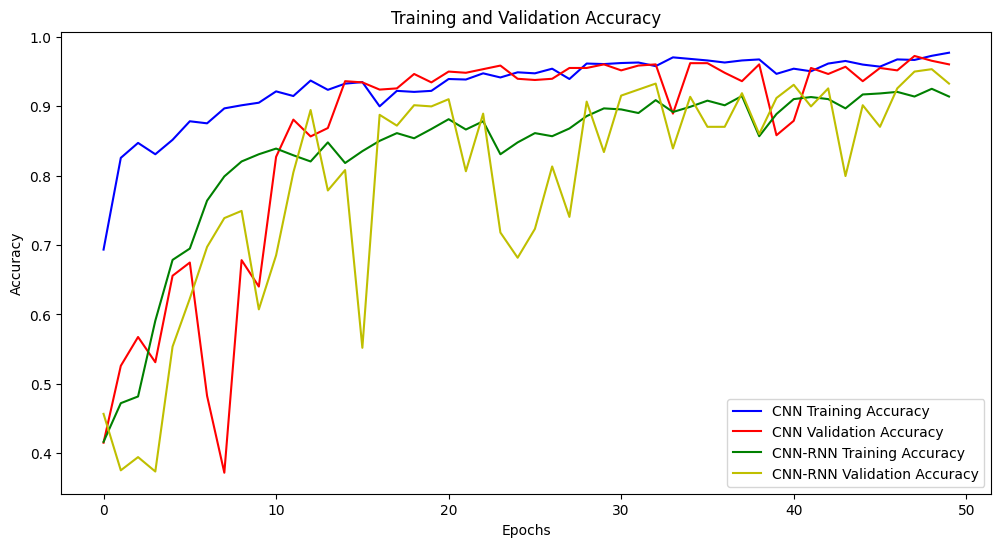

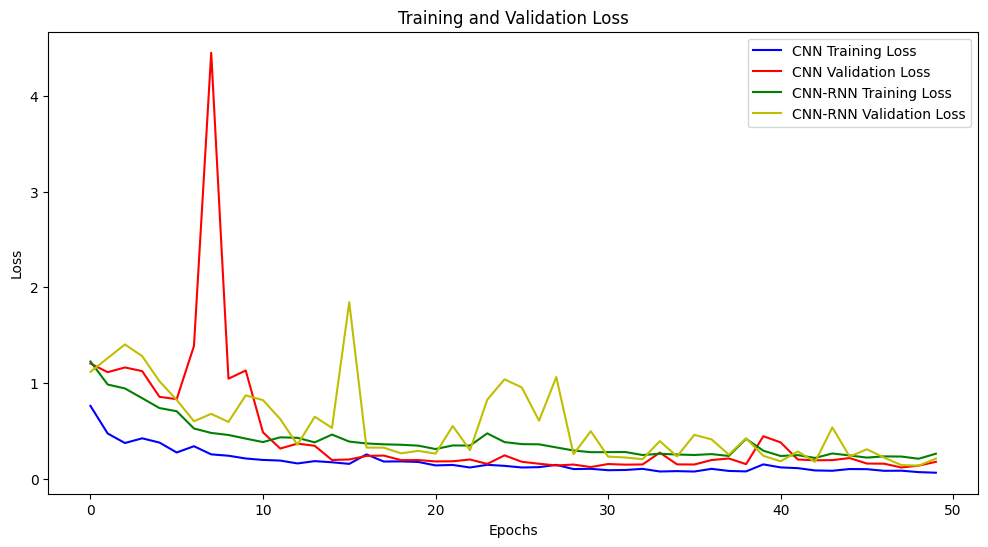

In [35]:
import matplotlib.pyplot as plt

# Extract metrics from history
accuracy_CNN = history_CNN['accuracy']
val_accuracy_CNN = history_CNN['val_accuracy']
loss_CNN = history_CNN['loss']
val_loss_CNN = history_CNN['val_loss']

accuracy_CNN_RNN = history_CNN_RNN['accuracy']
val_accuracy_CNN_RNN = history_CNN_RNN['val_accuracy']
loss_CNN_RNN = history_CNN_RNN['loss']
val_loss_CNN_RNN = history_CNN_RNN['val_loss']

# Debug prints to verify lengths and data
print("CNN Training Accuracy: ", accuracy_CNN)
print("CNN Validation Accuracy: ", val_accuracy_CNN)
print("CNN Training Loss: ", loss_CNN)
print("CNN Validation Loss: ", val_loss_CNN)

print("CNN-RNN Training Accuracy: ", accuracy_CNN_RNN)
print("CNN-RNN Validation Accuracy: ", val_accuracy_CNN_RNN)
print("CNN-RNN Training Loss: ", loss_CNN_RNN)
print("CNN-RNN Validation Loss: ", val_loss_CNN_RNN)

epochs_CNN = list(range(len(accuracy_CNN_RNN)))
epochs_CNN_RNN = list(range(len(accuracy_CNN_RNN)))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_CNN, accuracy_CNN, "b", label="CNN Training Accuracy")
plt.plot(epochs_CNN, val_accuracy_CNN, "r", label="CNN Validation Accuracy")
plt.plot(epochs_CNN_RNN, accuracy_CNN_RNN, "g", label="CNN-RNN Training Accuracy")
plt.plot(epochs_CNN_RNN, val_accuracy_CNN_RNN, "y", label="CNN-RNN Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_CNN, loss_CNN, "b", label="CNN Training Loss")
plt.plot(epochs_CNN, val_loss_CNN, "r", label="CNN Validation Loss")
plt.plot(epochs_CNN_RNN, loss_CNN_RNN, "g", label="CNN-RNN Training Loss")
plt.plot(epochs_CNN_RNN, val_loss_CNN_RNN, "y", label="CNN-RNN Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# classification report

In [54]:
labels_new = ["Closed", "Open","yawn","no_yawn"]

In [55]:
from keras.models import load_model
# Make predictions
best_model_CNN_RNN = load_model("/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN_RNN.h5")
predictions_CNN = best_model_CNN.predict(X_test)
predictions_CNN_RNN = best_model_CNN_RNN.predict(X_test)

# Convert predictions to label indices
predicted_classes_CNN = np.argmax(predictions_CNN, axis=1)
predicted_classes_CNN_RNN = np.argmax(predictions_CNN_RNN, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


In [56]:
from sklearn.metrics import classification_report
# Classification report for CNN
print("Classification Report for CNN:\n")
report_CNN = classification_report(np.argmax(y_test, axis=1), predicted_classes_CNN, target_names=labels_new)
print(report_CNN)

# Classification report for CNN-RNN
print("Classification Report for CNN-RNN:\n")
report_CNN_RNN = classification_report(np.argmax(y_test, axis=1), predicted_classes_CNN_RNN, target_names=labels_new)
print(report_CNN_RNN)

Classification Report for CNN:

              precision    recall  f1-score   support

      Closed       0.12      0.73      0.20        63
        Open       0.43      0.77      0.55        74
        yawn       0.00      0.00      0.00       215
     no_yawn       1.00      0.22      0.36       226

    accuracy                           0.26       578
   macro avg       0.39      0.43      0.28       578
weighted avg       0.46      0.26      0.23       578

Classification Report for CNN-RNN:

              precision    recall  f1-score   support

      Closed       0.20      0.65      0.31        63
        Open       0.14      0.15      0.14        74
        yawn       0.73      0.61      0.66       215
     no_yawn       0.94      0.48      0.63       226

    accuracy                           0.50       578
   macro avg       0.50      0.47      0.44       578
weighted avg       0.68      0.50      0.55       578



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Confusion matrix

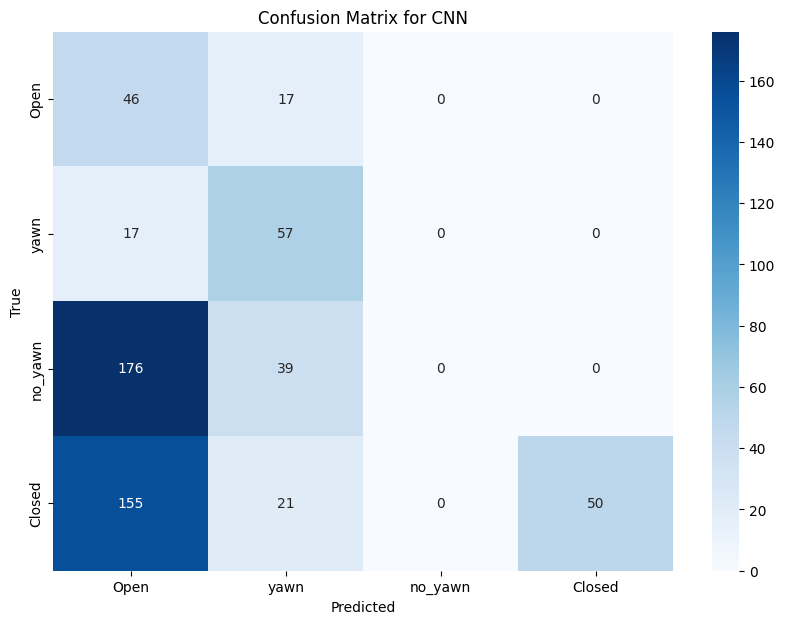

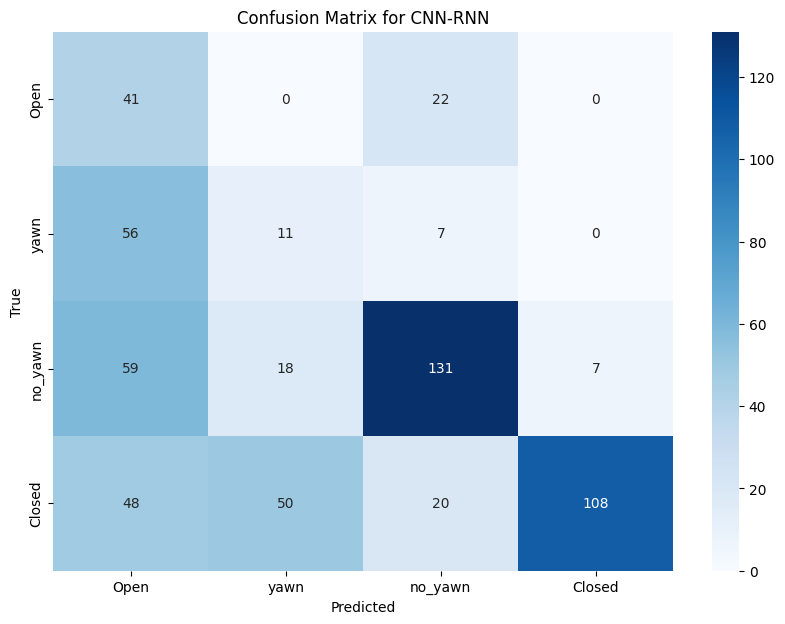

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrices
cm_CNN = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes_CNN)
cm_CNN_RNN = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes_CNN_RNN)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title, labels_new):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_new, yticklabels=labels_new)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Define class labels
labels_new = [ "Open","yawn", "no_yawn", "Closed",]

# Plot confusion matrices
plot_confusion_matrix(cm_CNN, "Confusion Matrix for CNN", labels_new)
plot_confusion_matrix(cm_CNN_RNN, "Confusion Matrix for CNN-RNN", labels_new)


In [ ]:
from keras.models import load_model
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming your model and history files are in the specified paths
best_model_CNN = load_model("/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN.h5")
best_model_CNN_RNN = load_model("/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN_RNN.h5")

history_path_CNN = "/content/drive/MyDrive/Eye_Classification/history_and_model/history_CNN.pkl"
history_path_CNN_RNN = "/content/drive/MyDrive/Eye_Classification/history_and_model/history_CNN_RNN.pkl"

with open(history_path_CNN, 'rb') as file:
    history_CNN = pickle.load(file)
with open(history_path_CNN_RNN, 'rb') as file:
    history_CNN_RNN = pickle.load(file)

# Print the overall accuracy for the CNN model
print(f"Overall CNN Model Accuracy: {history_CNN['val_accuracy'][-1]:.4f}")

# Print the overall accuracy for the CNN-RNN model
print(f"Overall CNN-RNN Model Accuracy: {history_CNN_RNN['val_accuracy'][-1]:.4f}")


Overall CNN Model Accuracy: 0.9602
Overall CNN-RNN Model Accuracy: 0.9325


# predicting function

In [45]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    try:
        img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
        img_array = img_array / 255
        resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    except Exception as e:
        print("Error occurred while reading the image file:", e)
        return None

model = tf.keras.models.load_model("/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN_RNN.h5")

# Prediction
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [47]:
prediction = model.predict([prepare(r"/content/dataset/train/Closed/_100.jpg")])
np.argmax(prediction)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=('Tensor(shape=(1, 145, 145, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2

In [48]:
prediction = model.predict([prepare(r"/content/dataset/train/Open/_113.jpg")])
np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


3

In [53]:
prediction = model.predict([prepare(r"/content/dataset/train/yawn/13.jpg")])
np.argmax(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


0